In [109]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from knn_regression_cf import *
from f1_measure_cf import *

from collections import defaultdict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Prepare data

In [3]:
dataset_path = '/home/artem/Documents/ITMO/Master/ML/Labs/dataset_191_wine.csv'
dataset_columns = ['wine_type', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
                   'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
                   'color_intensity', 'hue', 'od280_od315_of_diluted_wines', 'proline']
dataset = pd.read_csv(dataset_path, sep=',', header=0, names=dataset_columns)

In [4]:
dataset.head()

,wine_type,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
dataset.describe()

,wine_type,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [6]:
dataset.dtypes

wine_type                         int64
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                         int64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280_od315_of_diluted_wines    float64
proline                           int64
dtype: object

In [26]:
dataset_y = dataset.wine_type

In [15]:
dataset_x = dataset.drop('wine_type', axis='columns')
dataset_x_norm = (dataset_x - dataset_x.min()) / (dataset_x.max() - dataset_x.min())

In [17]:
dataset_x_norm.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.518584,0.315484,0.538244,0.458502,0.323278,0.453487,0.356386,0.437460,0.372523,0.322363,0.388170,0.491460,0.334446
std,0.213639,0.220780,0.146708,0.172142,0.155244,0.215811,0.210730,0.234818,0.180555,0.197806,0.185831,0.260070,0.224613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350658,0.170455,0.454545,0.340206,0.195652,0.262931,0.182489,0.264151,0.264984,0.165529,0.245935,0.244505,0.158702
50%,0.531579,0.222332,0.534759,0.458763,0.304348,0.474138,0.378692,0.396226,0.361199,0.290956,0.394309,0.553114,0.282097
75%,0.696711,0.462945,0.640374,0.561856,0.402174,0.627586,0.534810,0.580189,0.485804,0.419795,0.520325,0.695971,0.504280
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
dataset_x_norm.isna().values.any()

False

# Classification to regression

### Naive way

In [27]:
dataset_y.dtype

dtype('int64')

In [57]:
def predict(distance_name, kernel_name, k, x_train, y_train, x_test):
        distances = []
        for i, x in enumerate(x_train):
            distance = calculate_distance(distance_name, x_test, x)
            distances.append(distance)
            
        h = sorted(distances)[k]
            
        weights = []
        for d in distances:
            kernel_x = d / (10e-6 if h == 0 else h)
            weights.append(calculate_weight(kernel_name, kernel_x))
            
        weights_sum = sum(weights)
        y_test = sum([w * y for w, y in zip(weights, y_train)]) / weights_sum if weights_sum > 0 else 10e-6
        
        return round(y_test)
    

In [108]:
def evaluate_k(k, dataset_x_norm, dataset_y):
    c_to_tp = defaultdict(int)
    c_to_fn = defaultdict(int)
    c_to_fp = defaultdict(int)
    c_to_n = defaultdict(int)

    for i in range(len(dataset_y)):
        x_train = dataset_x_norm.drop(i, axis='index').values
        y_train = dataset_y.drop(i, axis='index').values
        x_test = dataset_x_norm.iloc[i].values
        y_test = dataset_y.iloc[i]

        y_pred = predict('manhattan', 'epanechnikov', k, x_train, y_train, x_test)

        c_to_tp[y_test] += 1 if y_test == y_pred else 0
        c_to_fn[y_test] += 1 if y_test != y_pred else 0
        c_to_fp[y_pred] += 1 if y_test != y_pred else 0
        c_to_n[y_test] += 1

    micro_f1, macro_f1 = calculate_f_measures(c_to_tp, c_to_fn, c_to_fp, c_to_n)
    return micro_f1, macro_f1

micro_f1, macro_f1 = evaluate_k(15, dataset_x_norm, dataset_y)
print(micro_f1, macro_f1)

0.971720592899789 0.9725421684314255


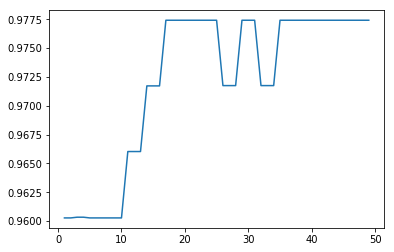

In [111]:
def plot_f_measure_by_k(dataset_x_norm, dataset_y):
    ks = list(range(1, 50, 1))
    f1_measures = []
    
    for k in ks:
        micro_f1, macro_f1 = evaluate_k(k, dataset_x_norm, dataset_y)
        f1_measures.append(micro_f1)
        
    plt.plot(ks, f1_measures)
    plt.show()

plot_f_measure_by_k(dataset_x_norm, dataset_y)